In [ ]:
# preliminary-analysis-2024-comb-building.ipynb
#
# Bryan Daniels
# 2024/3/29
#
# Continuing analysis started in 2021, looking for predictors of comb-building
# and thinking about ways the dynamics of the total amount of comb-building 
# could be modeled
#

In [1]:
import pandas as pd
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
%matplotlib inline
from toolbox import defaultFigure
defaultFigure.setDefaultParams()
from toolbox import gifsicle
from importlib import reload  
import datetime as dt
import random
import cProfile
from tqdm import tqdm

In [2]:
# import stuff from jacob davidson's github repository: https://github.com/jacobdavidson/bees_drones_2019data
from bees_drones_2019data import displayfunctions as bp  # 'bee plots'
from bees_drones_2019data import datafunctions as dfunc
from bees_drones_2019data import definitions_2019 as bd
dfunc.init(bd) 
bp.init(bd)
bd.year

2019

# Load data

The days with festoons are roughly (1) between day 4 and 20 and (2) between day 46 and 65

In [22]:
days_to_load = np.arange(0,10) #np.arange(16,24) #np.arange(0,10) #[4,]

## Load 5-minute behavioral data

(Note that these data are in a different format than what was loaded in `preliminary-analysis-2021-comb-building.ipynb`)

In [23]:
# data from 2019: https://zenodo.org/records/7298798
behavioral_data_dir = '../Data/240329/df_day5min/'

In [24]:
dfList = [ pd.read_hdf('{}df_day5min_{:03d}.hdf'.format(behavioral_data_dir,daynum)) for daynum in days_to_load ]
dfFiveMinute = pd.concat(dfList)

In [25]:
# time conversion
minutes_per_division = 5
divisions_per_day = int(24*60/minutes_per_division)
dfFiveMinute['Time (days)'] = dfFiveMinute['Day number'] + dfFiveMinute['timedivision']/divisions_per_day

In [157]:
# note: frame counts in the "festoon" column are sometimes fractional.  this seems to be because 
# regions in the hive are sometimes categorized not as a single region type but as a weighted
# combination of different region types.  this seems to be a way to deal with the fact that the
# regions are not hand-categorized every day, so days that are in between observed days are 
# treated as a weighted average of the observed days.  see e.g. dfunc.get_closest_measurements(9)

## Load trajectory data

In [7]:
trajectory_days_to_load = [4,]

In [8]:
# data from 2019: https://zenodo.org/records/7298798
trajectory_data_dir = '../Data/231018/trajectories_000-019/'

In [9]:
#dfTrajList = [ pd.read_hdf('{}beetrajectories_{:03d}.hdf'.format(trajectory_data_dir,daynum)) for daynum in days_to_load ]
#dfTraj = pd.concat(dfTrajList) # avoid explicitly creating list to save memory
filenames = [ '{}beetrajectories_{:03d}.hdf'.format(trajectory_data_dir,daynum) for daynum in trajectory_days_to_load ]
dfTraj = pd.concat(map(pd.read_hdf,filenames))

In [10]:
# time conversion
frames_per_second = 3
frames_per_day = 24*60*60*frames_per_second
dfTraj['Time (days)'] = dfTraj['daynum'] + dfTraj['framenum']/frames_per_day

In [11]:
dfTraj.head()

,daynum,framenum,uid,x,y,camera,theta,Time (days)
0,4,0,4,576,4770,0,2.84584,4.000000
1,4,6,4,563,4762,0,-3.06435,4.000023
2,4,7,4,563,4762,0,-3.11650,4.000027
3,4,8,4,557,4762,0,-2.96840,4.000031
4,4,9,4,557,4757,0,-2.99306,4.000035


In [12]:
print("Trajectories use {:.1f} GB of memory.".format(dfTraj.memory_usage().sum()/1e9))

Trajectories use 8.2 GB of memory.


## Load comb contents data

In [7]:
# data from 2019: https://zenodo.org/records/7298798
comb_contents_dir = '../Data/240329/comb-contents-images2019/'

In [8]:
# load the comb structure
combDict = dict([ (daynum, pickle.load(gzip.open(comb_contents_dir+'comb_{:03d}.pklz'.format(daynum),'rb'))) for daynum in days_to_load ])

In [9]:
combDict[4]

# Find bees that are festooning a lot or a little, and compare their trajectories

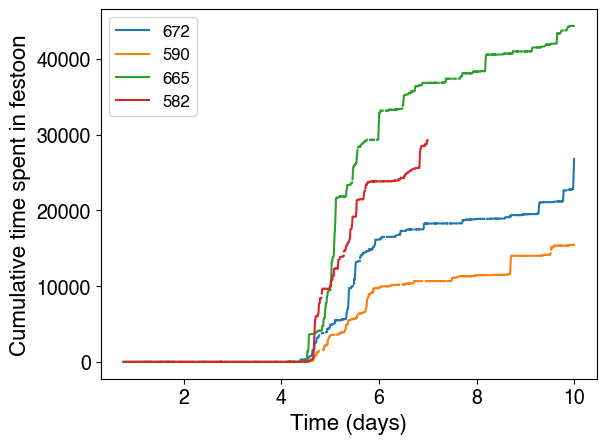

In [10]:
# sanity check: recreating a plot from preliminary-analysis-2021-comb-building.ipynb
# (largest festooners)
for beeID in [672,590,665,582]:
    dfFiveMinuteBee = dfFiveMinute[dfFiveMinute['Bee unique ID']==beeID]
    times = dfFiveMinuteBee['Time (days)']
    cumulativeFestoon = np.cumsum(dfFiveMinuteBee['Festoon'])
    plt.plot(times,cumulativeFestoon,label=beeID)
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Cumulative time spent in festoon');

In [123]:
def plot_bees_at_time(dfTraj,daynum,framenum,ax=[],show_comb=True,show_frame=False,color='crimson'):

    if show_comb: # quite slow compared to showframe
        ax = bp.showcomb(combDict[daynum],ax=ax)
    if show_frame:
        ax = bp.showframe(ax=ax)
    #plt.figure()
    #ax = plt.gca()
    dfTraj_one_frame = dfTraj[(dfTraj['daynum']==daynum) & (dfTraj['framenum']==framenum)]
    #print(dfTraj_one_frame)
    # for beeid in dfTraj_one_frame['uid'].unique():
    #     dfTraj_one_frame_one_bee = dfTraj_one_frame[dfTraj_one_frame['uid']==beeid]
    #     bp.plotbee_xy(dfTraj_one_frame_one_bee['x'],dfTraj_one_frame_one_bee['y'],dfTraj_one_frame_one_bee['camera'],
    #                   ax=ax,color='white',s=100,joined=False)
    return bp.plotbee_xy(dfTraj_one_frame['x'],dfTraj_one_frame['y'],dfTraj_one_frame['camera'],
                      ax=ax,color=color,s=100,joined=False)

In [124]:
def plot_history(dfTraj,beeid,start_time,delta_t,ax=[],show_comb=True,show_frame=False,joined=True,color='crimson',
                 show_id=False,maxxydiff=80):
    """
    Visualize a bee's history relative to a given start time
    
    See history_trajectory

    show_id (False)          : Display bee's id near its history trajectory (currently doesn't take into account 
                               camera data, so just uses vertical "y" data)
    """
    if show_comb: # quite slow compared to showframe
        ax = bp.showcomb(combDict[daynum],ax=ax)
    if show_frame:
        ax = bp.showframe(ax=ax)
    
    history = history_trajectory(dfTraj, beeid, start_time, delta_t)

    ax = bp.plotbee_xy(history['x'],history['y'],history['camera'],
                      ax=ax,color=color,joined=joined,maxxydiff=maxxydiff)

    if show_id:
        ax.text(0,np.mean(history['y']),beeid)
    
    return ax

In [128]:
# make animated gif of bee motion
daynum = 4
bee_subset = [415,577] #None #[665] #[582]
show_comb = False #True
show_frame = True #False
min_day_frac,max_day_frac = 0.6007,0.61007 #0.6,0.65 #0.,0.5
min_framenum,max_framenum = int(min_day_frac*frames_per_day),int(max_day_frac*frames_per_day)
frame_step = 5 #5 # number of frames to skip between renderings
framenums = range(min_framenum,max_framenum,frame_step)
print("Plotting day {}, frames {} (hour {}) to {} (hour {}) ({} frames)...".format(
    daynum,min_framenum,min_framenum/frames_per_day*24,max_framenum,max_framenum/frames_per_day*24,len(framenums)))
dfTraj_cut = dfTraj[(dfTraj['daynum']==daynum) & (min_framenum < dfTraj['framenum']) & (dfTraj['framenum'] < max_framenum)]
if bee_subset:
    dfTraj_cut = dfTraj_cut[dfTraj_cut['uid'].isin(bee_subset)]
plot_func = lambda framenum: plot_bees_at_time(dfTraj_cut,daynum,framenum,show_comb=show_comb,show_frame=show_frame)

gifsicle.gifsiclePlot(plot_func,
                          framenums,
                          '240528_bee_trajectories_day_{}_frame_{}_to_{}.gif'.format(daynum,min_framenum,max_framenum),
                          delay=1,
                          annotateList=[framenum_to_datetime(daynum,frame).strftime('%c') for frame in framenums])
plt.close('all')

Plotting day 4, frames 155701 (hour 14.416759259259258) to 158130 (hour 14.641666666666666) (486 frames)...


100%|█████████████████████████████████████████| 486/486 [00:42<00:00, 11.31it/s]


gifsicleAnnotate: GIF animation written to 240528_bee_trajectories_day_4_frame_155701_to_158130.gif


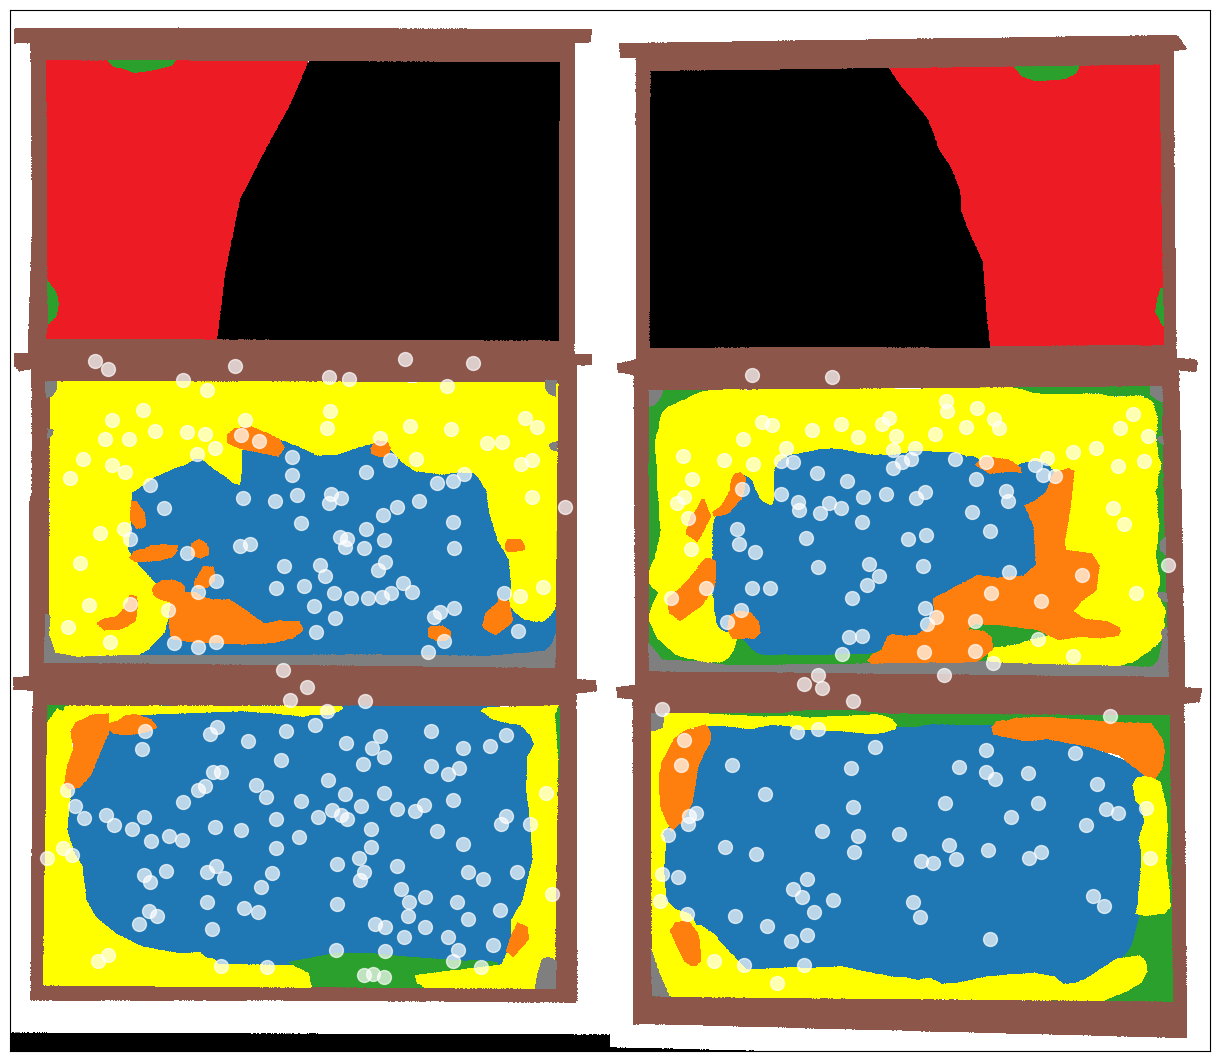

In [35]:
plot_bees_at_time(dfTraj,4,10)

<Axes: >

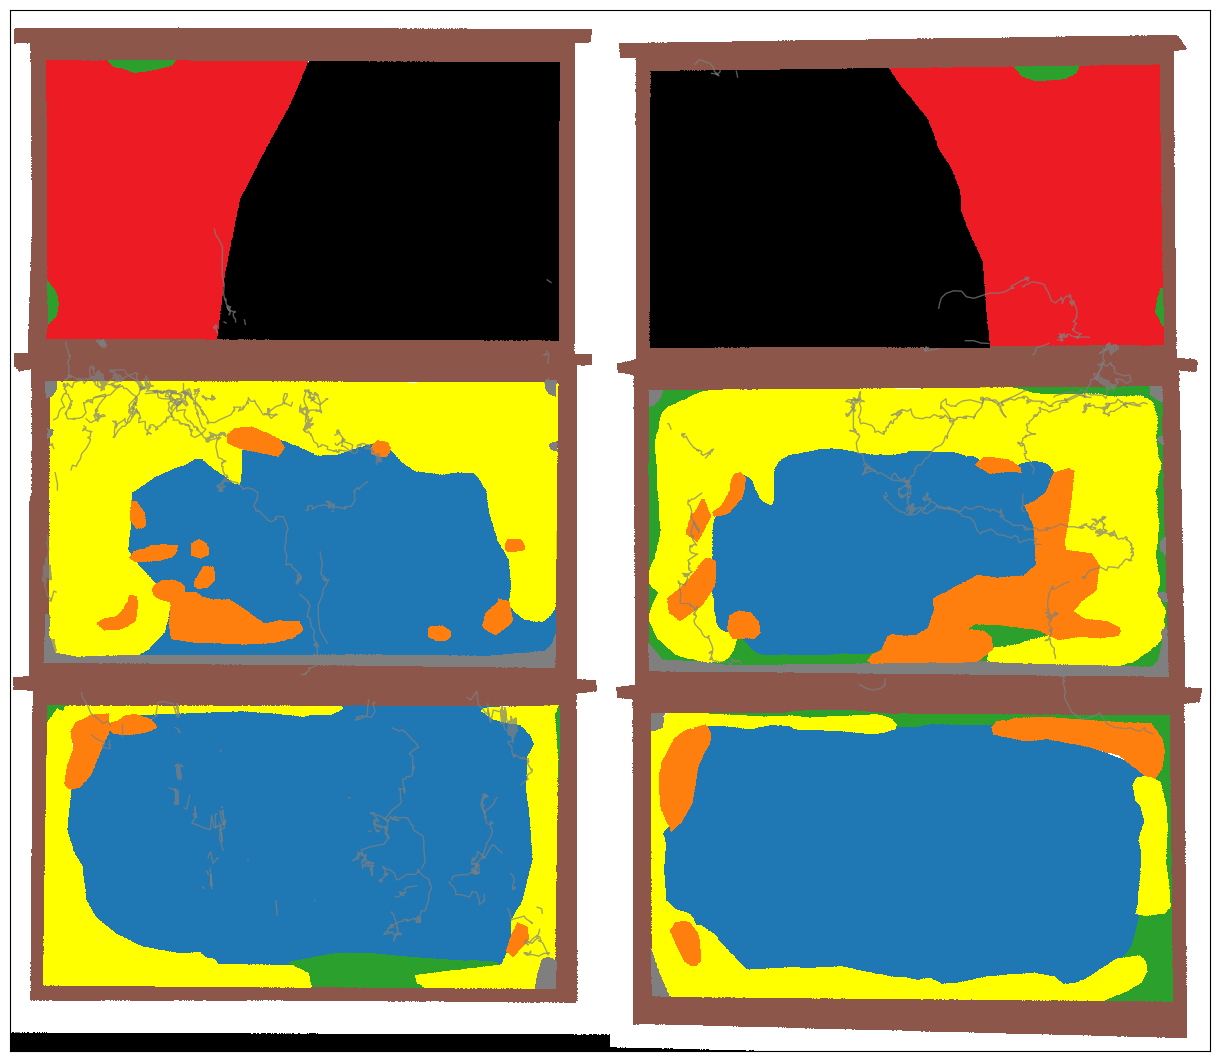

In [27]:
# plot trajectory of a single bee
beeID = 672 #582
minTime,maxTime = 4.3,4.4 # days
dfTraj_selected = dfTraj[(dfTraj['uid']==beeID) & (minTime < dfTraj['Time (days)']) & (dfTraj['Time (days)'] < maxTime)]

daynum = int(np.floor(minTime))
ax = bp.showcomb(combDict[daynum])
bp.plotbee_xy(dfTraj_selected['x'],dfTraj_selected['y'],dfTraj_selected['camera'],ax=ax,color='gray')
#bp.showframe(ax)

# what are statistics of in-festoon/out-of-festoon dynamics for individual bees?

In [99]:
# 2024/4/22 update festoon bout calculation to find specific time frame of each festoon bout start and end
# (one for each start/end that was computed with 5 minute resolution)
# *** Is the logic in datafunctions.py:line 437 incorrect?  It seems like this is the logic you'd want for the
# in/out of hive (since you want to keep track of when the bee is no longer observed), but not for changes
# between the bee being on different substrates?

In [ ]:
# odd: on day 4, one bee (bee 1522) shows up in the data often but with all NaNs

In [32]:
def bouts_from_time_series(series):
    """
    Takes pandas series indexed by time and returns dataframe with information about consecutive bouts
    over which behavior was constant.
    """
    # each element of bouts_list is a chunk of the original series over which behavior is constant
    bouts_list = np.split(series,np.where(np.diff(series)!=0)[0]+1)

    bouts_data = []
    for bout in bouts_list:
        bouts_data.append([bout.iloc[0],len(bout),bout.index[0],bout.index[-1]])

    return pd.DataFrame(bouts_data,columns=['Bout state','Bout length in time divisions','Bout start','Bout end'])

In [34]:
from time_functions_2019 import framenum_to_datetime,seconds_past_midnight,datetime_to_framenum,\
                                timediv_to_datetime,datetime_to_daynum

In [115]:
def add_speed_data(t,pixels_per_cm=80,frames_per_second=frames_per_second,max_delay_seconds=1,):
    """
    Adds speed data to a given trajectory dataFrame.

    Note: Assumes trajectory data is sorted in time order for each bee!

    max_delay_seconds (1)                  : Do not compute speeds for \Delta t > max_delay_seconds
                                             (as in bees_drones_2019data/
                                              Data processing - 1 - metrics and dataframes.ipynb/
                                              Data processing to calculate metrics)
    """
    
    t['delta x'] = np.concatenate([[np.nan],np.diff(t['x'])])
    t['delta y'] = np.concatenate([[np.nan],np.diff(t['y'])])
    t['delta framenum'] = np.concatenate([[np.nan],np.diff(t['framenum'])])
    t['delta camera'] = np.concatenate([[np.nan],np.diff(t['camera'])])
    t['delta uid'] = np.concatenate([[np.nan],np.diff(t['uid'])])

    # remove cases of different bees (note: unlikely not to already be caught by the time delay filter below?)
    t.loc[t['delta uid'] != 0, ['delta x',
                                'delta y',
                                'delta framenum',
                                'delta camera',
                                'speed (cm/s)']] = np.nan
    
    # compute speeds
    t['speed (cm/s)'] = np.linalg.norm([t['delta x'],t['delta y']],axis=0)/pixels_per_cm / (t['delta framenum']/frames_per_second)
    
    # implement maximum time delay (as in bees_drones_2019data)
    t.loc[t['delta framenum']/frames_per_second > max_delay_seconds, 'speed (cm/s)'] = np.nan

    # remove cases in which the bee is observed across different cameras (as in bees_drones_2019data)
    t.loc[t['delta camera'] != 0, 'speed (cm/s)'] = np.nan

In [122]:
import trajectory_analysis as traj

In [119]:
# takes ~30 seconds to add speed data to all trajectories from a single day
traj.add_speed_data(dfTraj)

In [35]:
# get_onsubstrate appears to be the equivalent of get_inout_estimates but for a particular substrate
# (the default substrate is "Festoon", which is what we want here)
# day_uids = list of bee ids (len # bees)
# day_ages = list of bee ages (len # bees)
# all_onsubstrate = array of inferred binary status of bees vs. time: on the substrate or not (shape #bees x #times)
# bee_obs = number of observations of each bee in each time window (shape #bees x #times)
# bee_data = all relevant data in a 3D array (?) (shape #bees x #times x #statistics)
df_festoon_list = []
for daynum in dfFiveMinute['Day number'].unique():
    # (Note: get_onsubstrate seems to be currently limited to one day at a time)
    dfFiveMinute_day = dfFiveMinute[dfFiveMinute['Day number']==daynum]
    day_uids, day_ages, all_onsubstrate, bee_obs, bee_data = dfunc.get_onsubstrate(dfFiveMinute_day)
    
    # construct binary dataframe for "in festoon" versus time for each bee
    df_festoon_list.append( pd.DataFrame(all_onsubstrate,
                    columns=[ timediv_to_datetime(int(daynum),timediv,divisions_per_day) for timediv in range(int(divisions_per_day))],
                    index=[ "Bee {}".format(uid) for uid in day_uids ]) )

df_festoon = pd.concat(df_festoon_list,axis=1)

# construct dataframe of festoon/non-festoon bouts for each bee 
bee_bouts_list = []
for beeid in df_festoon.index:
    bee_bouts = bouts_from_time_series(df_festoon.loc[beeid]).dropna()
    if len(bee_bouts) > 0:
        bee_bouts['Bee id'] = int(beeid.removeprefix('Bee '))
        bee_bouts['Bee start time'] = min(bee_bouts['Bout start'])
        bee_bouts['Bee final time'] = max(bee_bouts['Bout end'])
        bee_bouts_list.append(bee_bouts)
df_festoon_bouts = pd.concat(bee_bouts_list).set_index('Bee id')

# include time conversion
df_festoon_bouts['Bout length in minutes'] = df_festoon_bouts['Bout length in time divisions']*minutes_per_division
#df_festoon_bouts['Bout start minute'] = df_festoon_bouts['Bout start'].apply(lambda s: int(s.removeprefix('Minute ')))
#df_festoon_bouts['Bout end minute'] = df_festoon_bouts['Bout end'].apply(lambda s: int(s.removeprefix('Minute ')))

# exclude the bouts that start at first possible time or end at last possible time
df_non_cut_bouts = df_festoon_bouts[ 
    (df_festoon_bouts['Bout start']!=df_festoon_bouts['Bee start time']) & (df_festoon_bouts['Bout end']!=df_festoon_bouts['Bee final time'])]

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/

In [36]:
def traj_substrate_names(dfTraj,combDict):
    """
    Get substrate names from trajectory data.

    (Only tested so far on trajectory data from a single day.  Will fail at least if trajectory data are not ordered by day)
    """
    names_list = []
    for daynum in dfTraj['daynum'].unique():
        cmb = combDict[daynum]
        dfTraj_daynum = dfTraj[dfTraj['daynum']==daynum]
        substrate_numbers = np.array(cmb.getsubstrate(dfTraj_daynum['camera'],dfTraj_daynum['x'],dfTraj_daynum['y'])[0],dtype=int)
        names_list.extend(np.array(bd.substrate_names)[substrate_numbers])
    return names_list

In [55]:
def history_trajectory(dfTraj,beeid,start_time,delta_t):
    """
    Return the trajectory of a given bee leading up to an event time, delta_t minutes into the past.

    delta_t:    In minutes.

    Does not currently work for histories that span more than one calendar day (e.g. spanning across midnight)
    """

    min_time_daynum = datetime_to_daynum( start_time - dt.timedelta(minutes=delta_t) )
    min_time_framenum = datetime_to_framenum( start_time - dt.timedelta(minutes=delta_t) )
    max_time_daynum = datetime_to_daynum( start_time )
    max_time_framenum = datetime_to_framenum( start_time )

    if min_time_daynum != max_time_daynum:
        raise Exception("History spans across midnight, which is not yet supported")

    dfTraj_bee = dfTraj[dfTraj['uid']==beeid]
    dfTraj_bee_day = dfTraj_bee[dfTraj_bee['daynum']==min_time_daynum]
    return dfTraj_bee_day[ (dfTraj_bee_day['framenum'] < max_time_framenum) & (dfTraj_bee_day['framenum'] > min_time_framenum) ]

In [56]:
def first_festoon_times_fine(df_bouts,dfTraj,combDict):
    """
    Given festoon bout data at the coarse level (time divisions of size minutes_per_division),
    find first festoon time for each bee at the level of single camera frames.

    df_bouts                : Pandas dataFrame listing festoon and non-festoon bouts at the coarse time
                              scale, indexed by bee id.  Should contain columns for 'Bout state' and 
                              'Bout start'.  Bouts should be sorted in time for each bee.  The time of the
                              first festoon observation for each bout is between the 'Bout start' time and
                              one time division later.
    dfTraj                  : Pandas dataFrame containing fine-timescale trajectory data.  Should be sorted
                              in time for each bee.
    combDict                : Dictionary indexed by daynum containing comb contents data.

    Has not been tested for bouts near the transition between days (near midnight).
    """
    first_festoon_times_list = []
    # loop over bees
    for beeid in tqdm(df_bouts.index.unique()):
        
        # find first bout start time for this bee at the coarse level, which sets min_start_time
        df_bout_starts = df_bouts[df_bouts['Bout state']==1]
        min_start_time = df_bout_starts.loc[[beeid]]['Bout start'].iloc[0]
        
        
        max_start_time = min_start_time + dt.timedelta(minutes=minutes_per_division)
        if datetime_to_daynum(min_start_time) != datetime_to_daynum(max_start_time):
            # skip cases near midnight.  they are not dealt with yet in the history function, 
            # and are likely spurious due to changing the comb map at midnight
            print('first_festoon_times_fine: Skipping bee {} with first festoon near midnight'.format(beeid))
            first_festoon_frame = np.nan
            first_festoon_daynum = np.nan
            first_festoon_time = np.nan
        else:
            # get fine-scale trajectory of bee in the relevant time division and the corresponding substrates for each frame
            hist = history_trajectory(dfTraj,beeid,max_start_time,minutes_per_division)
            hist['substrate'] = traj_substrate_names(hist,combDict)
    
            # find first frame corresponding to festoon
            if len(hist[hist['substrate']=='festoon']) > 0:
                first_festoon_frame = hist[hist['substrate']=='festoon'].iloc[0]['framenum']
                first_festoon_daynum = datetime_to_daynum(min_start_time)
                first_festoon_time = framenum_to_datetime(first_festoon_daynum,first_festoon_frame)
            else:
                #print(min_start_time)
                #print(max_start_time)
                #print(hist['substrate'])
                print('first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee {}'.format(beeid))
                first_festoon_frame = np.nan
                first_festoon_daynum = np.nan
                first_festoon_time = np.nan
        
        first_festoon_times_list.append([ beeid, first_festoon_time, first_festoon_daynum, first_festoon_frame ])

    return pd.DataFrame(first_festoon_times_list,
                        columns=['Bee id','First festoon time','First festoon daynum','First festoon frame'])

In [57]:
first_festoon_times = first_festoon_times_fine(df_non_cut_bouts,dfTraj,combDict)
first_festoon_times.set_index('Bee id',inplace=True)

  6%|██▎                                      | 88/1595 [00:04<01:02, 23.98it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 551


 11%|████▎                                   | 172/1595 [00:07<01:00, 23.59it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 675


 11%|████▍                                   | 179/1595 [00:08<00:57, 24.52it/s]

first_festoon_times_fine: Skipping bee 692 with first festoon near midnight
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 699


 12%|████▋                                   | 188/1595 [00:08<00:58, 24.01it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 714


 13%|█████▏                                  | 209/1595 [00:09<00:58, 23.75it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 741


 15%|██████                                  | 242/1595 [00:10<00:56, 23.86it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 800


 16%|██████▌                                 | 260/1595 [00:11<00:57, 23.40it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 818
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 820


 17%|██████▋                                 | 266/1595 [00:11<00:56, 23.54it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 829


 17%|██████▉                                 | 275/1595 [00:12<00:57, 23.09it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 839


 18%|███████▏                                | 287/1595 [00:12<00:55, 23.63it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 861
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 863


 20%|███████▊                                | 314/1595 [00:13<00:53, 23.85it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 891
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 893
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 896


 21%|████████▎                               | 329/1595 [00:14<00:53, 23.85it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 909
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 915


 22%|████████▋                               | 344/1595 [00:15<00:52, 23.86it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 930


 22%|████████▊                               | 350/1595 [00:15<00:52, 23.68it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 939


 23%|█████████                               | 359/1595 [00:15<00:52, 23.50it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 947


 24%|█████████▋                              | 386/1595 [00:16<00:52, 22.91it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 979


 25%|█████████▊                              | 392/1595 [00:17<00:51, 23.26it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 987


 25%|█████████▉                              | 398/1595 [00:17<00:52, 22.86it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 998


 26%|██████████▎                             | 410/1595 [00:17<00:50, 23.58it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1009
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1010


 43%|█████████████████▎                      | 692/1595 [00:30<00:42, 21.45it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1356


 44%|█████████████████▌                      | 701/1595 [00:30<00:39, 22.66it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1368


 46%|██████████████████▎                     | 731/1595 [00:31<00:38, 22.40it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1404
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1405


 47%|██████████████████▊                     | 749/1595 [00:32<00:36, 23.20it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1421


 49%|███████████████████▌                    | 779/1595 [00:33<00:33, 24.05it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1455


 49%|███████████████████▋                    | 785/1595 [00:34<00:33, 23.84it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1460


 50%|███████████████████▊                    | 791/1595 [00:34<00:33, 23.73it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1469


 51%|████████████████████▌                   | 821/1595 [00:35<00:32, 23.68it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1499


 53%|█████████████████████▎                  | 851/1595 [00:37<00:31, 23.71it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1533


 54%|█████████████████████▋                  | 863/1595 [00:37<00:30, 23.76it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1545


 61%|████████████████████████▌               | 977/1595 [00:42<00:26, 23.71it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1661


 64%|████████████████████████▊              | 1013/1595 [00:43<00:24, 23.99it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 683


 71%|███████████████████████████▊           | 1136/1595 [00:49<00:19, 23.50it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1819


 73%|████████████████████████████▌          | 1166/1595 [00:50<00:18, 23.58it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1849
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1853
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1854


 74%|████████████████████████████▋          | 1175/1595 [00:50<00:18, 22.83it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1859


 76%|█████████████████████████████▌         | 1208/1595 [00:52<00:16, 23.36it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1892
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1893


 76%|█████████████████████████████▊         | 1220/1595 [00:52<00:16, 22.97it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1904


 77%|█████████████████████████████▉         | 1226/1595 [00:52<00:15, 23.30it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1911


 77%|██████████████████████████████         | 1232/1595 [00:53<00:15, 23.43it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1917


 78%|██████████████████████████████▎        | 1238/1595 [00:53<00:15, 23.47it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1923
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1925


 78%|██████████████████████████████▌        | 1250/1595 [00:53<00:14, 23.88it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1934
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1935


 79%|██████████████████████████████▋        | 1256/1595 [00:54<00:14, 23.24it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1941


 79%|██████████████████████████████▊        | 1262/1595 [00:54<00:15, 21.97it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1946
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1947
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1950


 80%|███████████████████████████████        | 1271/1595 [00:54<00:14, 22.66it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1958


 80%|███████████████████████████████▏       | 1277/1595 [00:55<00:13, 23.20it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1964


 81%|███████████████████████████████▍       | 1286/1595 [00:55<00:13, 22.71it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1972


 81%|███████████████████████████████▌       | 1292/1595 [00:55<00:14, 20.64it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1978
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 1981


 83%|████████████████████████████████▏      | 1316/1595 [00:56<00:12, 22.23it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2003


 83%|████████████████████████████████▍      | 1325/1595 [00:57<00:11, 22.77it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2010


 83%|████████████████████████████████▌      | 1331/1595 [00:57<00:11, 22.56it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2017
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2018
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2020


 84%|████████████████████████████████▋      | 1337/1595 [00:57<00:11, 23.24it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2023
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2026


 84%|████████████████████████████████▉      | 1346/1595 [00:58<00:11, 22.62it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2034
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2036
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2037


 85%|█████████████████████████████████      | 1352/1595 [00:58<00:10, 22.70it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2039
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2040
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2041


 85%|█████████████████████████████████▏     | 1358/1595 [00:58<00:10, 22.86it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2044
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2045
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2046
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2048


 86%|█████████████████████████████████▎     | 1364/1595 [00:59<00:10, 23.09it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2050
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2053


 86%|█████████████████████████████████▌     | 1373/1595 [00:59<00:09, 22.65it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2062


 86%|█████████████████████████████████▋     | 1379/1595 [00:59<00:09, 22.54it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2068
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2073


 87%|█████████████████████████████████▊     | 1385/1595 [01:00<00:09, 23.23it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2074
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2076
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2077


 88%|██████████████████████████████████▏    | 1397/1595 [01:00<00:09, 19.83it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2091
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2092


 88%|██████████████████████████████████▍    | 1407/1595 [01:01<00:10, 18.56it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2099


 89%|██████████████████████████████████▌    | 1413/1595 [01:01<00:09, 19.87it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2106


 89%|██████████████████████████████████▋    | 1419/1595 [01:01<00:08, 20.63it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2113
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2114
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2119
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2120
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2121


 89%|██████████████████████████████████▊    | 1425/1595 [01:02<00:08, 20.47it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2122
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2124
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2126
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2127


 90%|██████████████████████████████████▉    | 1428/1595 [01:02<00:08, 20.23it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2129
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2132
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2133


 90%|███████████████████████████████████    | 1433/1595 [01:02<00:08, 18.32it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2138
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2139
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2141


 90%|███████████████████████████████████    | 1436/1595 [01:02<00:08, 19.08it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2144
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2146
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2147
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2149
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2150


 91%|███████████████████████████████████▎   | 1444/1595 [01:03<00:07, 19.15it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2155
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2156
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2159
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2161
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2164


 91%|███████████████████████████████████▍   | 1448/1595 [01:03<00:07, 18.98it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2166
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2168
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2171
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2176


 91%|███████████████████████████████████▌   | 1452/1595 [01:03<00:07, 18.95it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2177
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2180
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2184
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2186


 91%|███████████████████████████████████▋   | 1457/1595 [01:03<00:07, 19.57it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2187
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2188
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2189
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2190


 92%|███████████████████████████████████▋   | 1461/1595 [01:03<00:06, 19.48it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2192
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2193
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2195
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2197
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2198


 92%|███████████████████████████████████▊   | 1467/1595 [01:04<00:06, 20.34it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2200
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2202
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2203
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2204


 92%|████████████████████████████████████   | 1473/1595 [01:04<00:05, 20.39it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2206
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2208
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2209
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2212
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2216


 93%|████████████████████████████████████▏  | 1479/1595 [01:04<00:05, 20.23it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2230
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2235
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2237
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2238


 93%|████████████████████████████████████▎  | 1485/1595 [01:05<00:04, 22.92it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2239
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2054
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2078
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2245
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2249
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2252


 94%|████████████████████████████████████▌  | 1493/1595 [01:05<00:03, 27.73it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2255
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2258
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2261
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2263
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2284
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2289
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2292


 94%|████████████████████████████████████▋  | 1501/1595 [01:05<00:03, 31.01it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2296
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2297
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2299
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2300
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2301
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2303
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2304
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2305


 95%|████████████████████████████████████▉  | 1509/1595 [01:05<00:02, 33.07it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2306
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2313
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2315
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2316
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2320
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2323
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2324
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2334


 95%|█████████████████████████████████████  | 1517/1595 [01:06<00:02, 33.60it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2338
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2340
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2345
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2352
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2353
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2356
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2357
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2372


 96%|█████████████████████████████████████▎ | 1525/1595 [01:06<00:02, 34.29it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2373
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2374
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2375
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2376
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2377
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2378
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2386
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2393


 96%|█████████████████████████████████████▍ | 1533/1595 [01:06<00:01, 34.40it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2396
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2398
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2400
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2401
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2403
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2411
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2412
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2415


 97%|█████████████████████████████████████▋ | 1541/1595 [01:06<00:01, 34.61it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2419
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2420
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2422
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2423
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2427
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2430
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2432
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2439


 97%|█████████████████████████████████████▉ | 1549/1595 [01:06<00:01, 35.20it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2445
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2451
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2460
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2463
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2465
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2466
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2468
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2473


 98%|██████████████████████████████████████ | 1557/1595 [01:07<00:01, 35.01it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2477
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2482
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2483
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2492
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2494
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2495
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2496
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2497


 98%|██████████████████████████████████████▎| 1565/1595 [01:07<00:00, 34.39it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2504
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2506
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2511
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2512
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2514
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2516
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2520
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2524


 98%|██████████████████████████████████████▎| 1569/1595 [01:07<00:00, 27.66it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2528
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2529
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2531
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2534


 99%|██████████████████████████████████████▌| 1577/1595 [01:07<00:00, 30.91it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2537
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2538
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2540
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2541
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2544
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2548
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2555
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2556


 99%|██████████████████████████████████████▊| 1585/1595 [01:08<00:00, 32.66it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2559
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2560
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2561
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2563
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2565
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2567
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2577
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2578


100%|██████████████████████████████████████▉| 1593/1595 [01:08<00:00, 33.65it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2581
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2592
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2596
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2597
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2600
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2603
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2608
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2612


100%|███████████████████████████████████████| 1595/1595 [01:08<00:00, 23.33it/s]

first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2614
first_festoon_times_fine: WARNING: No matching frames found in trajectory data for bee 2616


In [275]:
# double-check that this is the first time division in which this bee was seen in festoon

dfFiveMinute_slice = dfFiveMinute[(dfFiveMinute['Day number']==daynum) & (dfFiveMinute['Bee unique ID']==beeid)]
dfFiveMinute_slice['Time'] = [ timediv_to_datetime(daynum,timediv,divisions_per_day) for timediv in dfFiveMinute_slice['timedivision'] ]
dfFiveMinute_slice[dfFiveMinute_slice['Festoon'] > 0][['Bee unique ID','Festoon','Time']]

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_72492/1937994525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFiveMinute_slice['Time'] = [ timediv_to_datetime(daynum,timediv,divisions_per_day) for timediv in dfFiveMinute_slice['timedivision'] ]


,Bee unique ID,Festoon,Time
281556,11.0,25.0,2019-06-09 15:10:00
283103,11.0,101.0,2019-06-09 15:15:00
284650,11.0,37.0,2019-06-09 15:20:00
286197,11.0,23.0,2019-06-09 15:25:00
293932,11.0,1.0,2019-06-09 15:50:00
298573,11.0,206.0,2019-06-09 16:05:00
300120,11.0,45.0,2019-06-09 16:10:00
301667,11.0,13.0,2019-06-09 16:15:00
303214,11.0,42.0,2019-06-09 16:20:00
304761,11.0,36.0,2019-06-09 16:25:00


<Axes: >

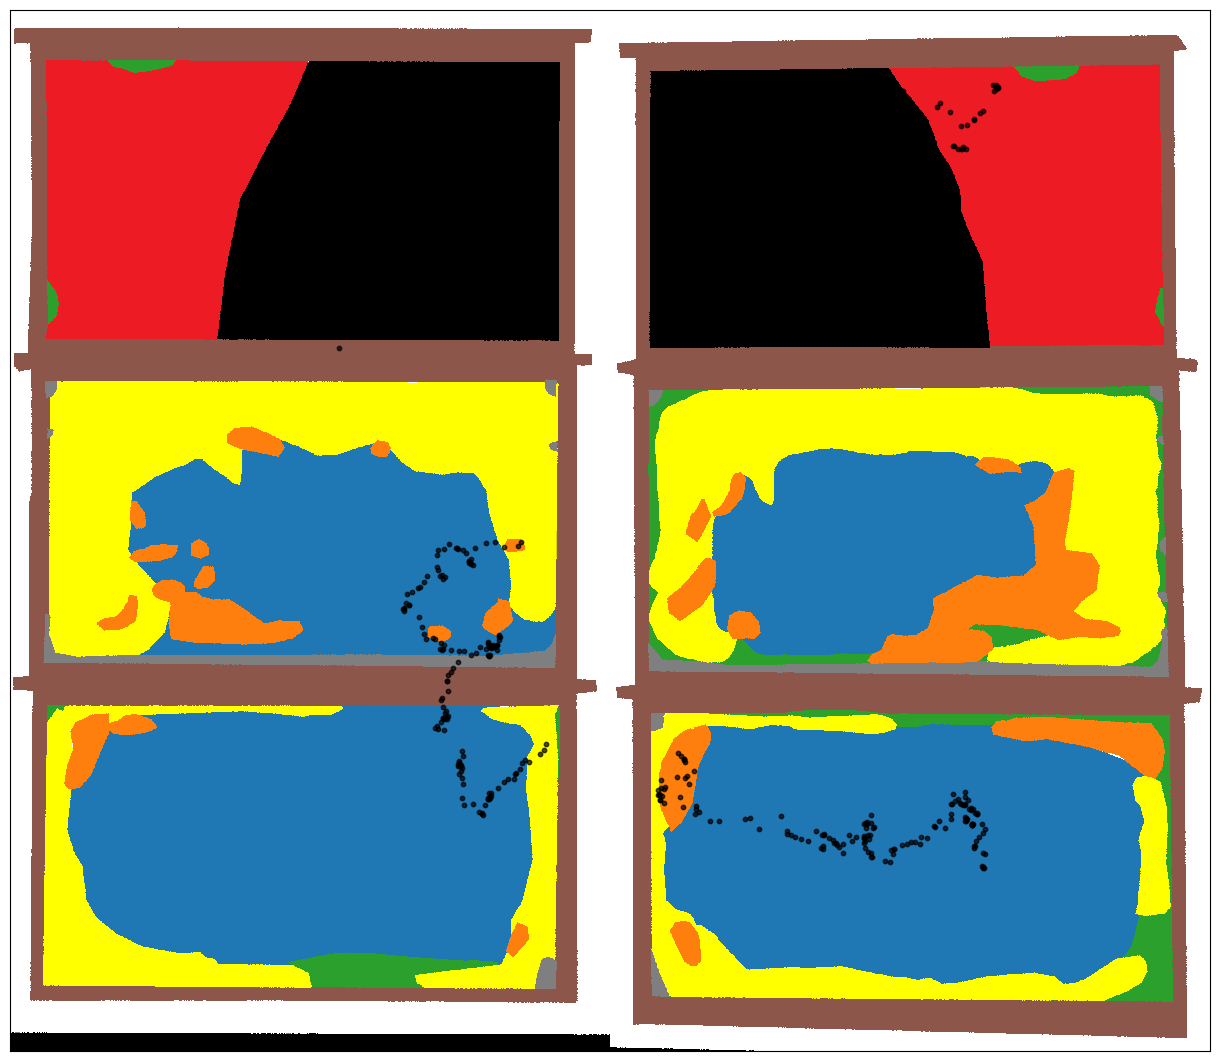

In [1051]:
plot_history(dfTraj,beeid,bout_start,minutes_per_division,color='k',joined=False)

In [39]:
festoon_bout_lengths = df_non_cut_bouts[df_non_cut_bouts['Bout state']==1]['Bout length in minutes']
nonfestoon_bout_lengths = df_non_cut_bouts[df_non_cut_bouts['Bout state']==0]['Bout length in minutes']
print("Festoon bouts:")
print("   Mean duration:   {:3.2f} minutes.".format(np.mean(festoon_bout_lengths)))
print("   Median duration: {:3.2f} minutes.".format(np.median(festoon_bout_lengths)))
print()
print("Non-Festoon bouts:")
print("   Mean duration:   {:3.2f} minutes.".format(np.mean(nonfestoon_bout_lengths)))
print("   Median duration: {:3.2f} minutes.".format(np.median(nonfestoon_bout_lengths)))

Festoon bouts:
   Mean duration:   9.54 minutes.
   Median duration: 5.00 minutes.

Non-Festoon bouts:
   Mean duration:   188.33 minutes.
   Median duration: 50.00 minutes.


(0.0, 400.0, 0.5959097687543721, 52627.09498042595)

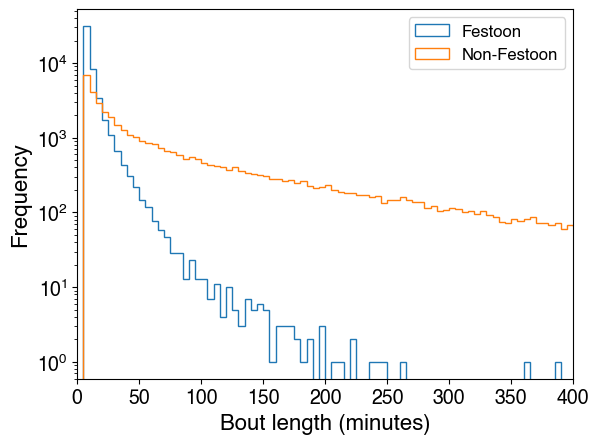

In [40]:
# plot histograms of lengths of festoon and non-festoon bouts
bins = minutes_per_division*np.arange(divisions_per_day)
df_non_cut_bouts[df_non_cut_bouts['Bout state']==1]['Bout length in minutes'].plot.hist(bins=bins,
                                                                                        label='Festoon',
                                                                                        histtype='step')
df_non_cut_bouts[df_non_cut_bouts['Bout state']==0]['Bout length in minutes'].plot.hist(bins=bins,
                                                                                        label='Non-Festoon',
                                                                                        histtype='step')
plt.xlabel('Bout length (minutes)')
plt.legend()
plt.yscale('log')
plt.axis(xmin=0,xmax=400)

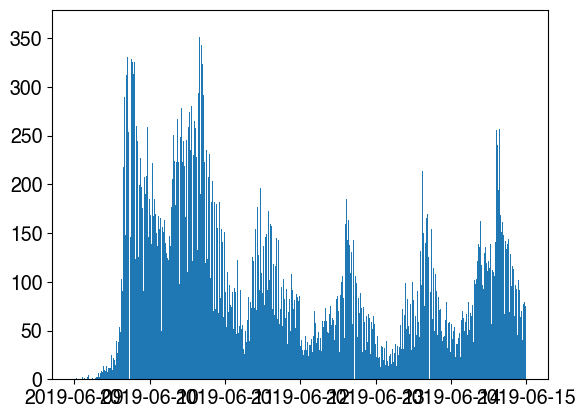

In [179]:
plt.hist(df_non_cut_bouts['Bout end'],bins=1000);

In [180]:
df_non_cut_bouts[(df_non_cut_bouts['Bout state']==1) & (df_non_cut_bouts['Bout length in minutes']>400)]

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
1072,True,92,2019-06-09 18:10:00,2019-06-10 01:45:00,2019-06-05,2019-06-11 23:55:00,460


## do bees vary in their bout length distributions?

(array([1.35e+03, 1.76e+02, 3.80e+01, 1.50e+01, 3.00e+00, 4.00e+00,
        1.00e+00, 4.00e+00, 1.00e+00, 3.00e+00]),
 array([   5. ,  249.5,  494. ,  738.5,  983. , 1227.5, 1472. , 1716.5,
        1961. , 2205.5, 2450. ]),
 <BarContainer object of 10 artists>)

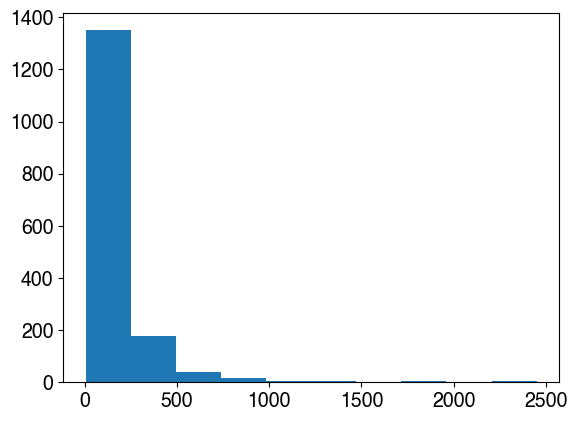

In [181]:
plt.hist(df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').mean())

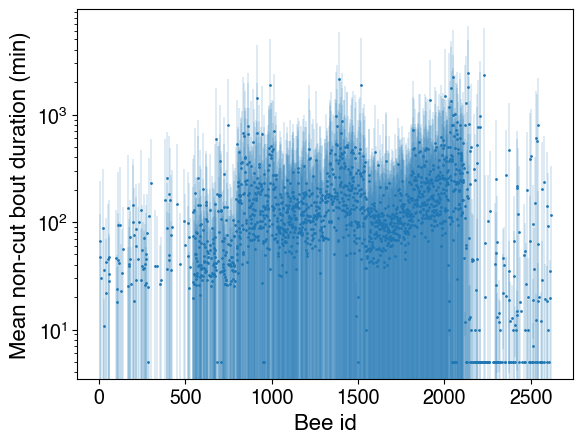

In [182]:
plt.errorbar(df_non_cut_bouts.index.unique(),
             df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').mean(),
             yerr=df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').std(),
             ls='',marker='o',ms=1,elinewidth=0.2)
plt.xlabel('Bee id')
plt.ylabel('Mean non-cut bout duration (min)')
plt.yscale('log')

Text(0, 0.5, 'Mean non-cut festoon duration (min)')

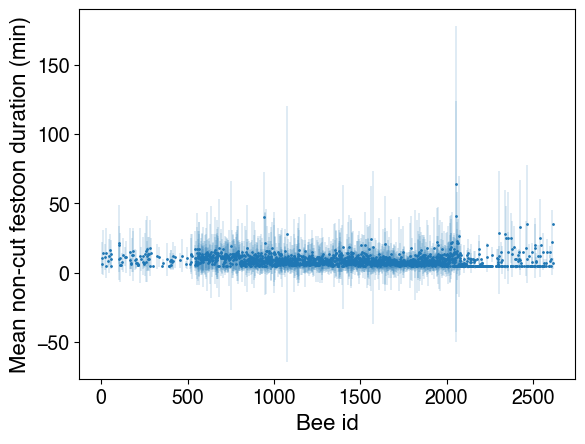

In [183]:
dff = df_non_cut_bouts[df_non_cut_bouts['Bout state']==1]
plt.errorbar(dff.index.unique(),
             dff['Bout length in minutes'].groupby('Bee id').mean(),
             yerr=dff['Bout length in minutes'].groupby('Bee id').std(),
             ls='',marker='o',ms=1,elinewidth=0.2)
plt.xlabel('Bee id')
plt.ylabel('Mean non-cut festoon duration (min)')
#plt.yscale('log')

# 2024/4/12 Find interaction events before festoon bouts

In [184]:
df_non_cut_bouts

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
4,True,3,2019-06-09 11:55:00,2019-06-09 12:05:00,2019-06-05,2019-06-10 23:55:00,15
4,False,48,2019-06-09 12:10:00,2019-06-09 16:05:00,2019-06-05,2019-06-10 23:55:00,240
4,True,1,2019-06-09 16:10:00,2019-06-09 16:10:00,2019-06-05,2019-06-10 23:55:00,5
4,False,19,2019-06-09 16:15:00,2019-06-09 17:45:00,2019-06-05,2019-06-10 23:55:00,95
4,True,1,2019-06-09 17:50:00,2019-06-09 17:50:00,2019-06-05,2019-06-10 23:55:00,5
...,...,...,...,...,...,...,...
2616,True,1,2019-06-13 19:40:00,2019-06-13 19:40:00,2019-06-12,2019-06-14 23:55:00,5
2616,False,67,2019-06-13 19:45:00,2019-06-14 01:15:00,2019-06-12,2019-06-14 23:55:00,335
2616,True,3,2019-06-14 01:20:00,2019-06-14 01:30:00,2019-06-12,2019-06-14 23:55:00,15


In [41]:
def interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=10):
    """
    Returns dataFrame listing interaction events during which the bee with ID beeID is nearby another bee, within
    the time window between minTime and maxTime.  Here "nearby" means within a distance threshold and on the same 
    side of the hive.

    dfTraj                   : Trajectory dataframe containing framenumbers, (x,y) coordinates, and camera information.
    minTime                  : Minimum time to scan for interaction events, as a datetime object
    maxTime                  : Maximum time to scan for interaction events, as a datetime object
    distance_thresh (10)     : Distance in pixels within which two bees must be imaged in the same frame to count as an interaction
    """
    # select trajectory data from all bees from the desired time window
    minFrame = datetime_to_framenum(minTime)
    maxFrame = datetime_to_framenum(maxTime)
    dfTraj_selected = dfTraj[(minFrame < dfTraj['framenum']) & (dfTraj['framenum'] < maxFrame)]

    # select trajectory data from the selected bee
    dfTraj_selected_bee = dfTraj_selected[dfTraj_selected['uid']==beeID]
    
    # loop over time looking for interaction events
    interaction_data = []
    for frame in dfTraj_selected_bee['framenum'].unique():
        all_bee_frame_data = dfTraj_selected[dfTraj_selected['framenum']==frame]
        
        # get selected bee location for this time frame
        selected_bee_frame_data = all_bee_frame_data[all_bee_frame_data['uid']==beeID]
        beex = selected_bee_frame_data['x'].iloc[0],
        beey = selected_bee_frame_data['y'].iloc[0]
        beecamera = selected_bee_frame_data['camera'].iloc[0]

        # find distances from all other bees seen by the same camera (same side of hive) at this time frame
        all_bee_frame_data_same_side = all_bee_frame_data[all_bee_frame_data['camera']==beecamera]
        distances = pd.Series(np.linalg.norm([all_bee_frame_data_same_side['x']-beex,
                                              all_bee_frame_data_same_side['y']-beey],axis=0),
                              index=all_bee_frame_data_same_side['uid'])

        # append interaction data
        for other_bee in distances[distances < distance_thresh].index:
            if other_bee != beeID:
                other_bee_frame_data = all_bee_frame_data_same_side[all_bee_frame_data_same_side['uid']==other_bee]
                assert(len(other_bee_frame_data)==1) # should only have one timepoint for one bee in one frame
                interaction_data.append([frame,
                                         other_bee,
                                         other_bee_frame_data['x'].iloc[0],
                                         other_bee_frame_data['y'].iloc[0],
                                         other_bee_frame_data['camera'].iloc[0],
                                         distances[other_bee]])
    
    return pd.DataFrame(interaction_data,columns=['framenum','uid','x','y','camera','distance (pixels)'])

In [58]:
beeID = 672 #672 #582
delta_t = 30 # minutes --- number of minutes to look at before the start of joining the festoon
# look at the first festoon bout for this bee
bout_start = first_festoon_times['First festoon time'].loc[beeID] #df_non_cut_bouts.loc[beeID].iloc[0]['Bout start']
minTime = bout_start - dt.timedelta(minutes=delta_t)
maxTime = bout_start

events = interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=100)

In [345]:
# translate frame numbers to absolute time

# for now daynum has to be set manually based on which trajectory data is currently loaded...
daynum = 4
events['time'] = events['framenum'].apply(lambda f: framenum_to_datetime(daynum,f))

In [346]:
events

,framenum,uid,x,y,camera,distance (pixels),time
0,85330,11,2372,2185,0,81.492331,2019-06-09 07:54:03.333333
1,85333,1233,2308,2047,0,88.391176,2019-06-09 07:54:04.333333
2,85336,1233,2309,2049,0,90.785461,2019-06-09 07:54:05.333333
3,85450,956,1985,2335,0,97.329338,2019-06-09 07:54:43.333333
4,85451,956,1984,2327,0,96.104110,2019-06-09 07:54:43.666667
...,...,...,...,...,...,...,...
871,90502,2206,350,2369,0,97.529483,2019-06-09 08:22:47.333333
872,90664,1497,2067,1868,0,84.403791,2019-06-09 08:23:41.333333
873,90665,1497,2067,1868,0,47.010637,2019-06-09 08:23:41.666667
874,90668,1497,2067,1872,0,41.785165,2019-06-09 08:23:42.666667


In [ ]:
# to do: would a pandas multiindex be faster for our purposes?  e.g. indexed by bee and framenum

# 2024/4/17 Compare recent interactions of festooning and non-festooning bees

In [43]:
print("A total of {} bees appear in the current loaded data.".format(len(dfFiveMinute['Bee unique ID'].unique())))

A total of 2056 bees appear in the current loaded data.


In [212]:
# construct dataframe with the first festoon bout for each bee
# (OLD as of 2024/4/24 --- now we use the fine-grained festoon start data)
#
# first_festoon_bouts = []
# for beeid in df_non_cut_bouts.index.unique():
#     if(type(df_non_cut_bouts.loc[beeid]) == pd.DataFrame):
#         first_bout = df_non_cut_bouts.loc[beeid].iloc[0]
#     else: # it's a Series because there's only one bout
#         first_bout = df_non_cut_bouts.loc[beeid]
#     assert(first_bout['Bout state']==1)
#     first_festoon_bouts.append(first_bout)
# df_first_festoon_bouts = pd.concat(first_festoon_bouts,axis=1).transpose()
# df_first_festoon_bouts.index.name = 'Bee id'

## restrict to specified time window

In [59]:
minTimeDays = 4.6 #4.5  # start of time window in days
deltaTimeHours = 2 # duration of time window in hours

# time conversions
daynum = int(np.floor(minTimeDays))
dayStartTime = timediv_to_datetime(daynum,0,divisions_per_day)
minTime = dayStartTime + dt.timedelta(days=minTimeDays-daynum)
maxTime = minTime + dt.timedelta(hours=deltaTimeHours)
maxTimeDays = datetime_to_daynum(maxTime) + seconds_past_midnight(maxTime)/(24*60*60)
minTime_frame = datetime_to_framenum(minTime)
maxTime_frame = datetime_to_framenum(maxTime)

# calculate restricted dataframes
dfFiveMinute_windowed = dfFiveMinute[(dfFiveMinute['Time (days)'] > minTimeDays) & (dfFiveMinute['Time (days)'] < maxTimeDays)]
df_non_cut_bouts_windowed = df_non_cut_bouts[(df_non_cut_bouts['Bout start'] > minTime) & (df_non_cut_bouts['Bout start'] < maxTime)]
df_non_cut_bout_starts_windowed = df_non_cut_bouts_windowed[df_non_cut_bouts_windowed['Bout state']==1]
# df_first_festoon_bouts_windowed = df_first_festoon_bouts[(df_first_festoon_bouts['Bout start'] > minTime) & \
#                                                          (df_first_festoon_bouts['Bout start'] < maxTime) ]
first_festoon_times_windowed = first_festoon_times[(first_festoon_times['First festoon time'] > minTime) & \
                                                         (first_festoon_times['First festoon time'] < maxTime) ]
dfTraj_windowed = dfTraj[(dfTraj['daynum']==daynum) & (dfTraj['framenum'] < maxTime_frame) & (dfTraj['framenum'] > minTime_frame)]

print("Restricting to time window starting at {} and ending at {}.".format(minTime,maxTime))
print()
print("In this time window, there are {} festoon bout start events.".format(len(df_non_cut_bout_starts_windowed)))
print("In this time window, there are {} first festoon bout start events.".format(len(first_festoon_times_windowed)))

Restricting to time window starting at 2019-06-09 14:24:00 and ending at 2019-06-09 16:24:00.

In this time window, there are 1407 festoon bout start events.
In this time window, there are 550 first festoon bout start events.


## split into 5 age groups (not yet used)

In [ ]:
# as in preliminary-analysis-2021-comb-building.ipynb

In [491]:
bins = [0,5,7,13,15,30] #2 #[0,5,10,30]
cut = pd.cut(dfFiveMinute['Age'],bins) # cut into bins
#cut = pd.qcut(dfMinuteBees['Age'],bins) # cut into quantiles
dfFiveMinuteAgeBinned = dfFiveMinute.groupby(cut)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_89447/779359619.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfFiveMinuteAgeBinned = dfFiveMinute.groupby(cut)


In [500]:
# number of bees in each age group
dfFiveMinuteAgeBinned['Bee unique ID'].unique().apply(len)

Age
(0, 5]      915
(5, 7]      775
(7, 13]     564
(13, 15]    519
(15, 30]    435
Name: Bee unique ID, dtype: int64

# Find interaction events in recent histories of new festooners and non-festooners

In [60]:
def interaction_partners(dfTraj,beeID,start_time,delta_t,distance_thresh,first_festoon_times,verbose=False):
    """
    Returns IDs of interaction partners of a given bee between start_time - delta_t and start_time, 
    and the subset of those that have festooned before the interaction.

    delta_t              : In minutes
    """

    minTime = start_time - dt.timedelta(minutes=delta_t)
    maxTime = start_time
    
    events = interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=distance_thresh)

    # translate frame numbers to absolute time
    daynum = datetime_to_daynum(start_time)
    events['time'] = events['framenum'].apply(lambda f: framenum_to_datetime(daynum,f))

    # find interaction partners and find which of them started festooning before the interaction event
    other_bees = events['uid'].unique()
    other_bees_that_festoon = [ bee for bee in other_bees if bee in first_festoon_times.index ]
    other_bees_that_festoon_before = [ bee for bee in other_bees_that_festoon \
                                       if first_festoon_times.loc[bee]['First festoon time'] < events[events['uid']==bee].iloc[0]['time'] ]

    if verbose:
        print("There are {} other bees that interact with bee {}.".format(len(other_bees),beeID))
        print("Of these, {} festoon at some point.".format(len(other_bees_that_festoon)))
        print("Of these, {} festooned before bee {} interacted with them.".format(len(other_bees_that_festoon_before),beeID))
        print()

    return other_bees,other_bees_that_festoon_before

In [120]:
delta_t = 2 #15 # minutes --- number of minutes to look at before the start of joining the festoon
distance_thresh = 80 #100 #50 # pixels (80 pixels / cm)

# we will define "non-festoon" bees as those that have trajectory data but do not festoon until after
# the end of the window plus a buffer time > delta_t

buffer_time_hours = 2 # (hours after the end of the window to filter out soon-to-be-festooning bees)
assert(buffer_time_hours > delta_t/60)

bee_ids_windowed = dfFiveMinute_windowed['Bee unique ID'].unique()
bee_ids_windowed_nonfestoon = [ bee for bee in bee_ids_windowed \
                    if (bee not in first_festoon_times_windowed.index) \
                    or (first_festoon_times_windowed.loc[bee]['First festoon time'] > maxTime + dt.timedelta(hours=buffer_time_hours)) ]

print("There are {} bees with data in the given time window.".format(len(bee_ids_windowed)))
print("Of these, {} are 'non-festoon' bees.".format(len(bee_ids_windowed_nonfestoon)))

# set random seed for choice of non-festooning bees
random.seed(12345)

interaction_data = []
interaction_data_nonfestoon = []
speed_data = []
speed_data_nonfestoon = []
for beeID in tqdm(first_festoon_times_windowed.index): 

    # look at the first festoon bout for this bee
    #bout_start = df_first_festoon_bouts_windowed.loc[beeID]['Bout start']
    bout_start = first_festoon_times_windowed.loc[beeID]['First festoon time']

    # find and record numbers of interaction partners for the festooning bee
    partners,festoon_partners = interaction_partners(dfTraj,beeID,bout_start,delta_t,
                                                     distance_thresh,first_festoon_times)
    interaction_data.append([ beeID, len(partners), len(festoon_partners) ])

    # now for non-festooning bees:
    # we will create a dataset that has one non-festooning bee trajectory
    # matched to have the same bout_start time as each of the festooning bees
    
    # pick a random non-festooning bee
    nonfestoon_beeID = random.choice(bee_ids_windowed_nonfestoon)

    # find numbers of interaction partners for the non-festooning bee
    partners_nonfestoon,festoon_partners_nonfestoon = interaction_partners(dfTraj,nonfestoon_beeID,bout_start,delta_t,
                                                      distance_thresh,first_festoon_times)
    interaction_data_nonfestoon.append([ nonfestoon_beeID, len(partners_nonfestoon), len(festoon_partners_nonfestoon) ])

    # find speed data for festooning and non-festooning bee
    history = history_trajectory(dfTraj,beeID,bout_start,delta_t)
    history_nonfestoon = history_trajectory(dfTraj,nonfestoon_beeID,bout_start,delta_t)
    if 'speed (cm/s)' not in history.columns:
        traj.add_speed_data(history)
        traj.add_speed_data(history_nonfestoon)
    speeds = history['speed (cm/s)']
    speeds_nonfestoon = history_nonfestoon['speed (cm/s)']
    prop_frames_seen = len(history)/(delta_t*60*frames_per_second)
    prop_frames_seen_nonfestoon = len(history_nonfestoon)/(delta_t*60*frames_per_second)
    speed_data.append([ beeID, np.mean(speeds), np.max(speeds), prop_frames_seen ])
    speed_data_nonfestoon.append([ nonfestoon_beeID, np.mean(speeds_nonfestoon), np.max(speeds_nonfestoon), prop_frames_seen_nonfestoon ])
    

cols = ['bee ID','interaction partners','interaction partners previously in festoon']
df_interaction_data = pd.DataFrame(interaction_data,columns=cols)
df_interaction_data_nonfestoon = pd.DataFrame(interaction_data_nonfestoon,columns=cols)

speed_cols = ['bee ID','avg speed (cm/s)','max speed (cm/s)','proportion of frames seen']
df_speed_data = pd.DataFrame(speed_data,columns=speed_cols)
df_speed_data_nonfestoon = pd.DataFrame(speed_data_nonfestoon,columns=speed_cols)

There are 1547 bees with data in the given time window.
Of these, 997 are 'non-festoon' bees.


100%|█████████████████████████████████████████| 550/550 [06:52<00:00,  1.33it/s]


Text(0.5, 0, 'Proportion of frames in which bee was seen in $\\Delta t$')

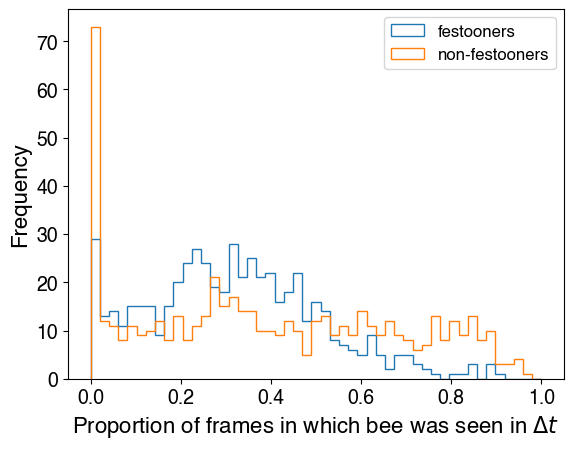

In [402]:
bins = np.linspace(0,1,50)
df_speed_data['proportion of frames seen'].plot.hist(bins=bins,histtype='step',
                                                                            label='festooners')
df_speed_data_nonfestoon['proportion of frames seen'].plot.hist(bins=bins,histtype='step',
                                                                                       label='non-festooners')
plt.legend()
plt.xlabel('Proportion of frames in which bee was seen in $\Delta t$')

In [413]:
many_interaction_bees = [825,844,876,990]
first_festoon_times_windowed.loc[many_interaction_bees]

,First festoon time,First festoon daynum,First festoon frame
Bee id,,,
825,2019-06-09 15:45:16.333333,4.0,170149.0
844,2019-06-09 15:44:03.000000,4.0,169929.0
876,2019-06-09 15:19:40.000000,4.0,165540.0
990,2019-06-09 16:10:26.333333,4.0,174679.0


<Axes: ylabel='Frequency'>

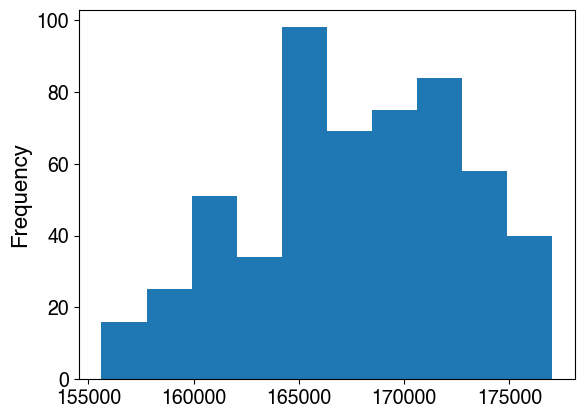

In [432]:
#first_festoon_times['First festoon frame'].dropna().plot.hist()
first_festoon_times_windowed['First festoon frame'].dropna().plot.hist()

<Axes: >

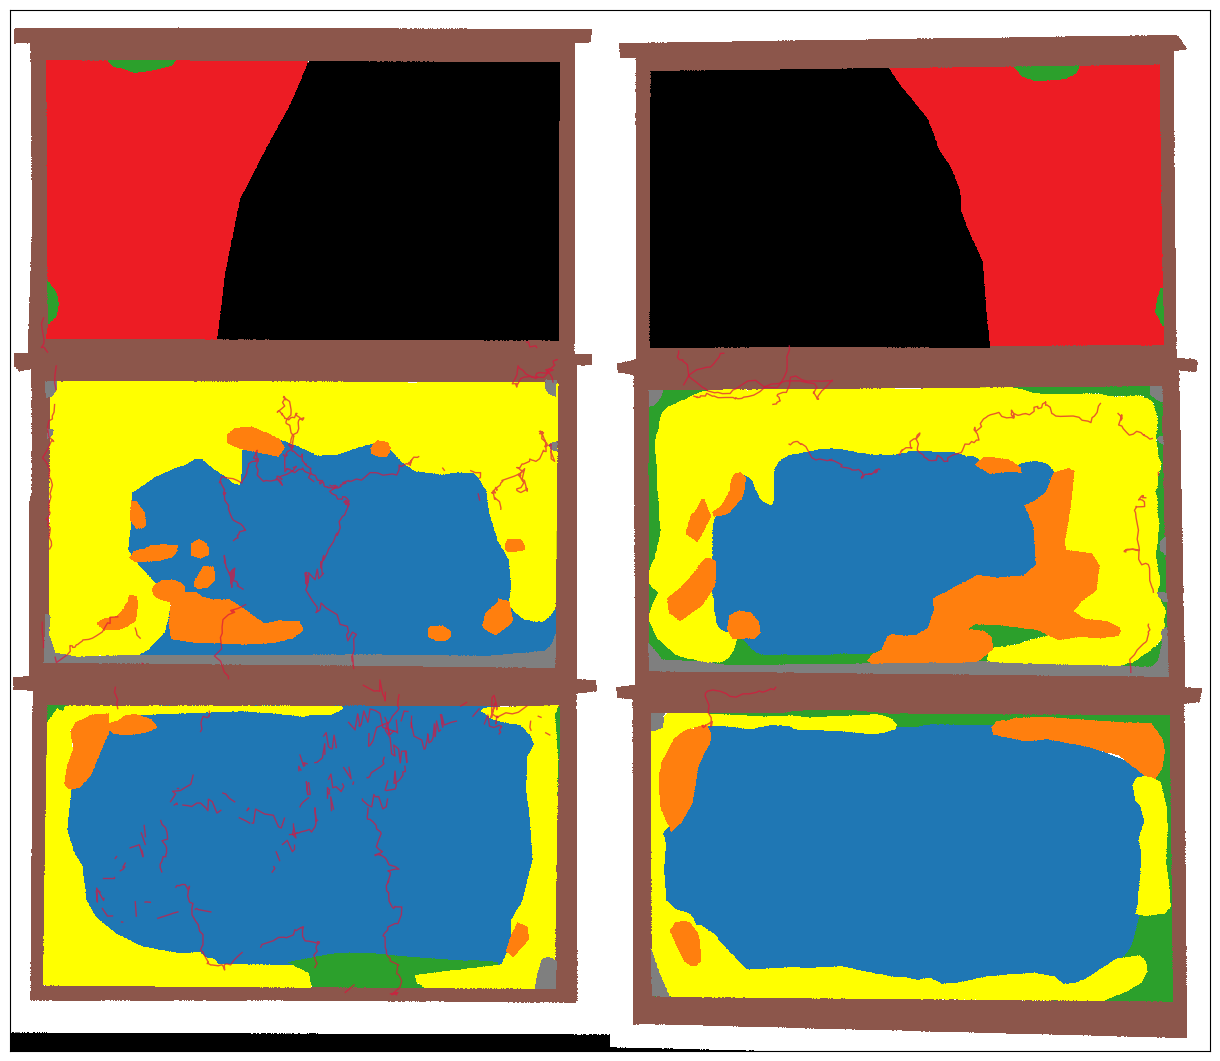

In [474]:
beeid = 825
plot_history(dfTraj,beeid,first_festoon_times_windowed.loc[beeid]['First festoon time'],15)

Text(0.5, 0, 'Interaction partners previously in festoon')

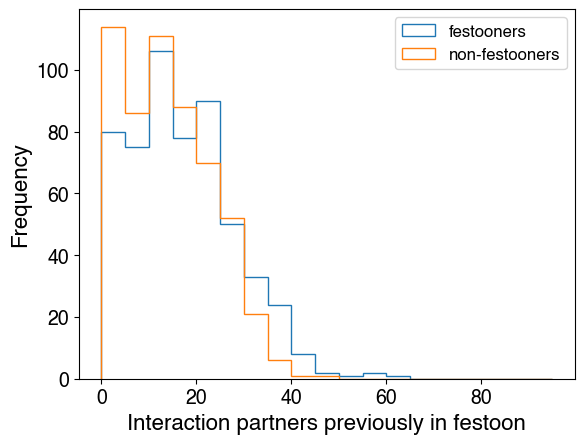

In [477]:
bins = range(0,100,5)
df_interaction_data['interaction partners previously in festoon'].plot.hist(bins=bins,histtype='step',
                                                                            label='festooners')
df_interaction_data_nonfestoon['interaction partners previously in festoon'].plot.hist(bins=bins,histtype='step',
                                                                                       label='non-festooners')
plt.legend()
plt.xlabel('Interaction partners previously in festoon')

Text(0.5, 0, 'Total interaction partners')

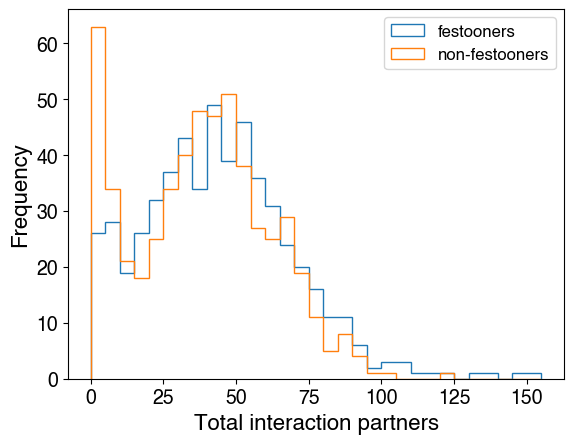

In [435]:
bins = range(0,max(df_interaction_data['interaction partners']),5)
df_interaction_data['interaction partners'].plot.hist(bins=bins,histtype='step',label='festooners')
df_interaction_data_nonfestoon['interaction partners'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Total interaction partners')

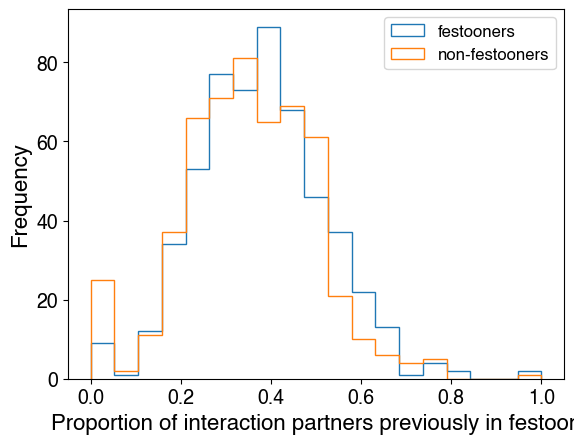

In [407]:
bins = np.linspace(0,1,20)
(df_interaction_data[
     'interaction partners previously in festoon']/df_interaction_data['interaction partners']).plot.hist(histtype='step',
                                                                                                          bins=bins,
                                                                                                          label='festooners')
(df_interaction_data_nonfestoon[
     'interaction partners previously in festoon']/df_interaction_data_nonfestoon['interaction partners']).plot.hist(histtype='step',
                                                                                                                     bins=bins,
                                                                                                                     label='non-festooners')
plt.xlabel('Proportion of interaction partners previously in festoon')
plt.legend()

Text(0.5, 0, 'Max speed (cm/s)')

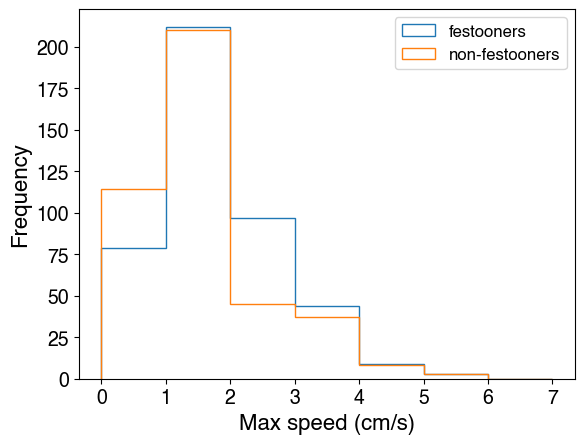

In [75]:
# 2024/5/28 new filtered speed
bins = range(0,int(np.ceil(max(df_speed_data['max speed (cm/s)'].dropna()))),1)
df_speed_data['max speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='festooners')
df_speed_data_nonfestoon['max speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Max speed (cm/s)')

Text(0.5, 0, 'Average speed (cm/s)')

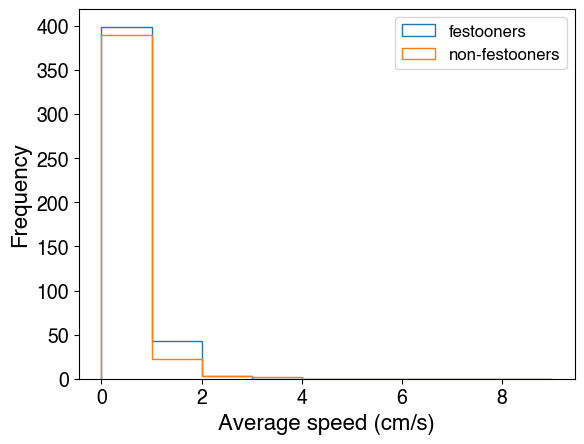

In [76]:
# 2024/5/28 new filtered speed
bins = range(0,10,1)
df_speed_data['avg speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='festooners')
df_speed_data_nonfestoon['avg speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Average speed (cm/s)')

In [77]:
num_festooners_seen = df_speed_data.count()['avg speed (cm/s)']
total_festooners = df_speed_data.count()['bee ID']
print("Out of {} total festooners, {} were seen in the {} minute history, and {} were not.".format(
    total_festooners,num_festooners_seen,delta_t,total_festooners-num_festooners_seen))

num_nonfestooners_seen = df_speed_data_nonfestoon.count()['avg speed (cm/s)']
total_nonfestooners = df_speed_data_nonfestoon.count()['bee ID']
print("Out of {} total non-festooners, {} were seen in the {} minute history, and {} were not.".format(
    total_nonfestooners,num_nonfestooners_seen,delta_t,total_nonfestooners-num_nonfestooners_seen))

Out of 550 total festooners, 445 were seen in the 2 minute history, and 105 were not.
Out of 550 total non-festooners, 417 were seen in the 2 minute history, and 133 were not.


## Are any bees going into the top frame before day 4?

In [748]:
dfFiveMinute.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'Mean x-shifted', 'Mean y', 'Bee unique ID', 'Cohort ID',
       'Num. outside trips', 'Num. dance floor visits',
       'Dispersion-minute avg.', 'Frame 0 - Num. crossings',
       'Frame 1 - Num. crossings', 'Frame 2 - Num. crossings',
       'Frame 3 - Num. crossings', 'Frame 4 - Num. crossings',
       'Frame 5 - Num. crossings', 'timedivision', 'Time (days)'],
      dtype='object')

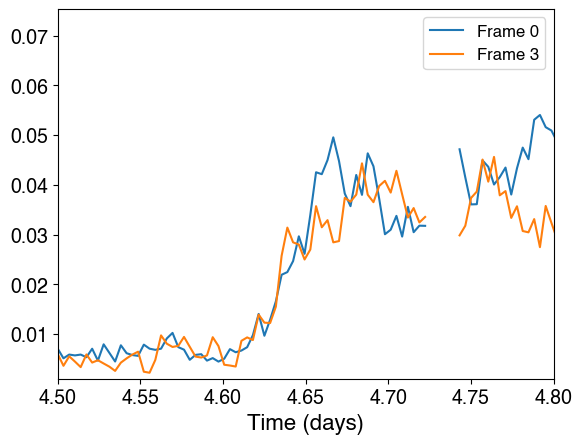

In [11]:
dfFiveMinute.groupby('Time (days)').mean()['Frame 0'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').mean()['Frame 3'].plot(label='Frame 3')
plt.axis(xmin=4.5,xmax=4.8,ymin=1e-3) # zoomed in to transition
#plt.axis(xmin=0,xmax=8,ymin=1e-4)     # zoomed out
plt.legend()
#plt.yscale('log')

<Axes: xlabel='Time (days)'>

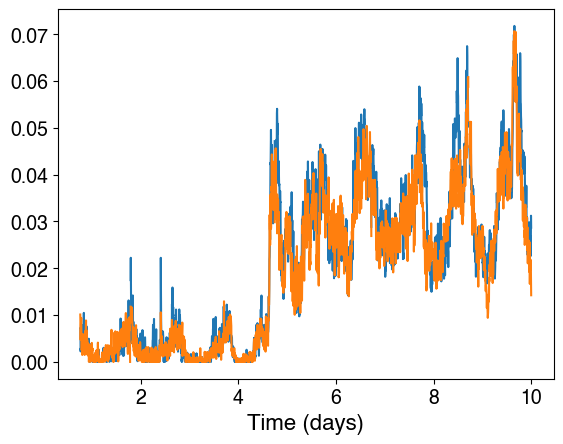

In [12]:
dfFiveMinute.groupby('Time (days)').mean()['Frame 0'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').mean()['Frame 3'].plot(label='Frame 3')

<Axes: xlabel='Time (days)'>

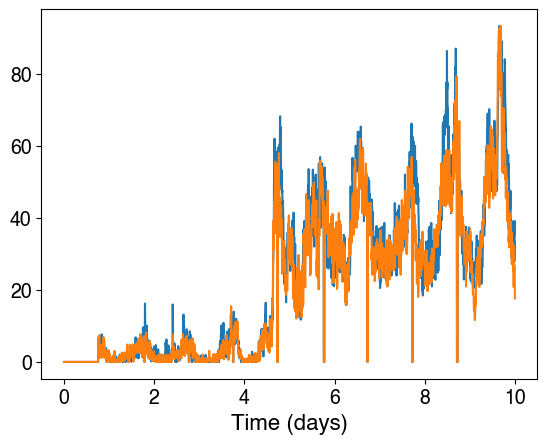

In [26]:
dfFiveMinute.groupby('Time (days)').sum()['Frame 0'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').sum()['Frame 3'].plot(label='Frame 3')

<Axes: xlabel='Time (days)'>

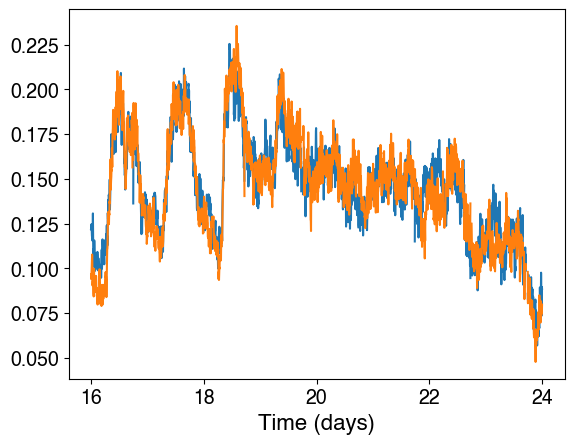

In [17]:
dfFiveMinute.groupby('Time (days)').mean()['Frame 0'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').mean()['Frame 3'].plot(label='Frame 3')

<Axes: xlabel='Time (days)'>

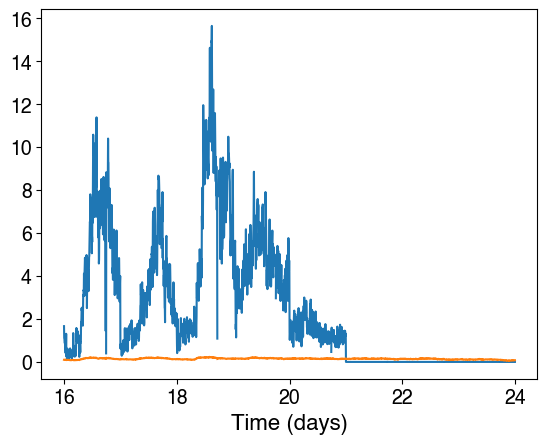

In [19]:
dfFiveMinute.groupby('Time (days)').mean()['Festoon'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').mean()['Frame 3'].plot(label='Frame 3')

## make animation showing trajectories of all first-festoon events in this time window

In [330]:
dfTraj.columns

Index(['daynum', 'framenum', 'uid', 'x', 'y', 'camera', 'theta',
       'Time (days)'],
      dtype='object')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


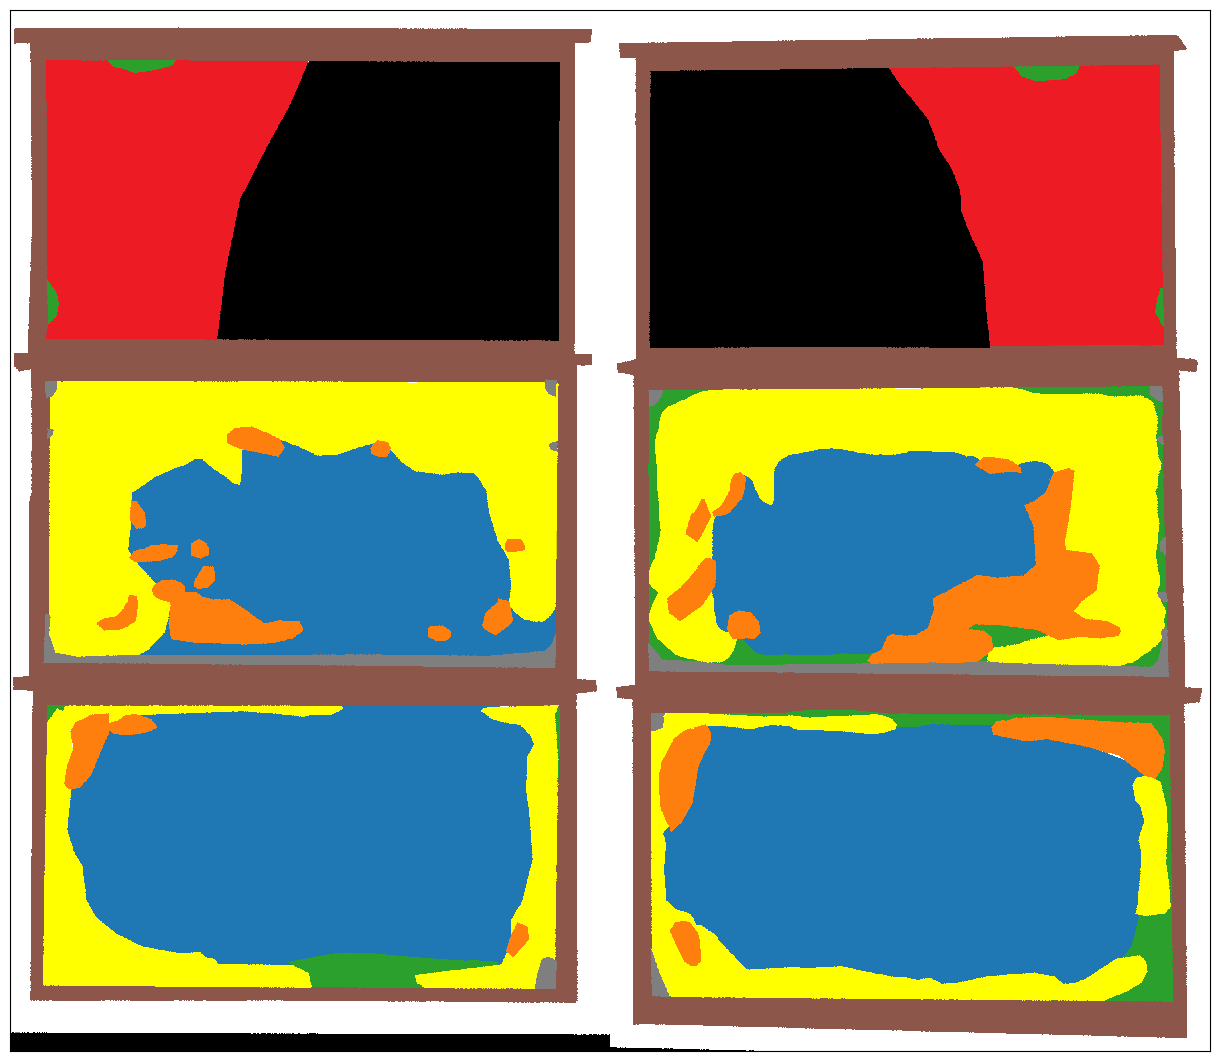

In [353]:
ax = plot_history(dfTraj,7,first_festoon_times_windowed.loc[7]['First festoon time'],2,color='white',show_id=True)

In [357]:
# make animated gif consisting of trajectories before first-festoon events
show_comb = False #True
show_frame = True #False
daynum = int(np.floor(minTimeDays))
make_animation = False #True
delta_t = 2 # minutes

def plot_func(beeid,delta_t=delta_t,ax=[]):
    bout_start = first_festoon_times_windowed.loc[beeid]['First festoon time']
    return plot_history(dfTraj_windowed,
                        beeid,
                        bout_start,
                        delta_t, 
                        show_comb=show_comb,
                        show_frame=show_frame,
                        ax=ax,
                        show_id=True,
                        maxxydiff=1e10)

beeIDs = list( first_festoon_times_windowed.index )

if make_animation:
    gifsicle.gifsiclePlot(plot_func,
                              beeIDs,
                              '240424_bee_histories_before_first_festoon_day{}_{}_to_{}.gif'.format(daynum,minTime.time(),maxTime.time()),
                              delay=1,
                              annotateList=["bee ID: {}".format(beeID) for beeID in beeIDs])
    plt.close('all')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

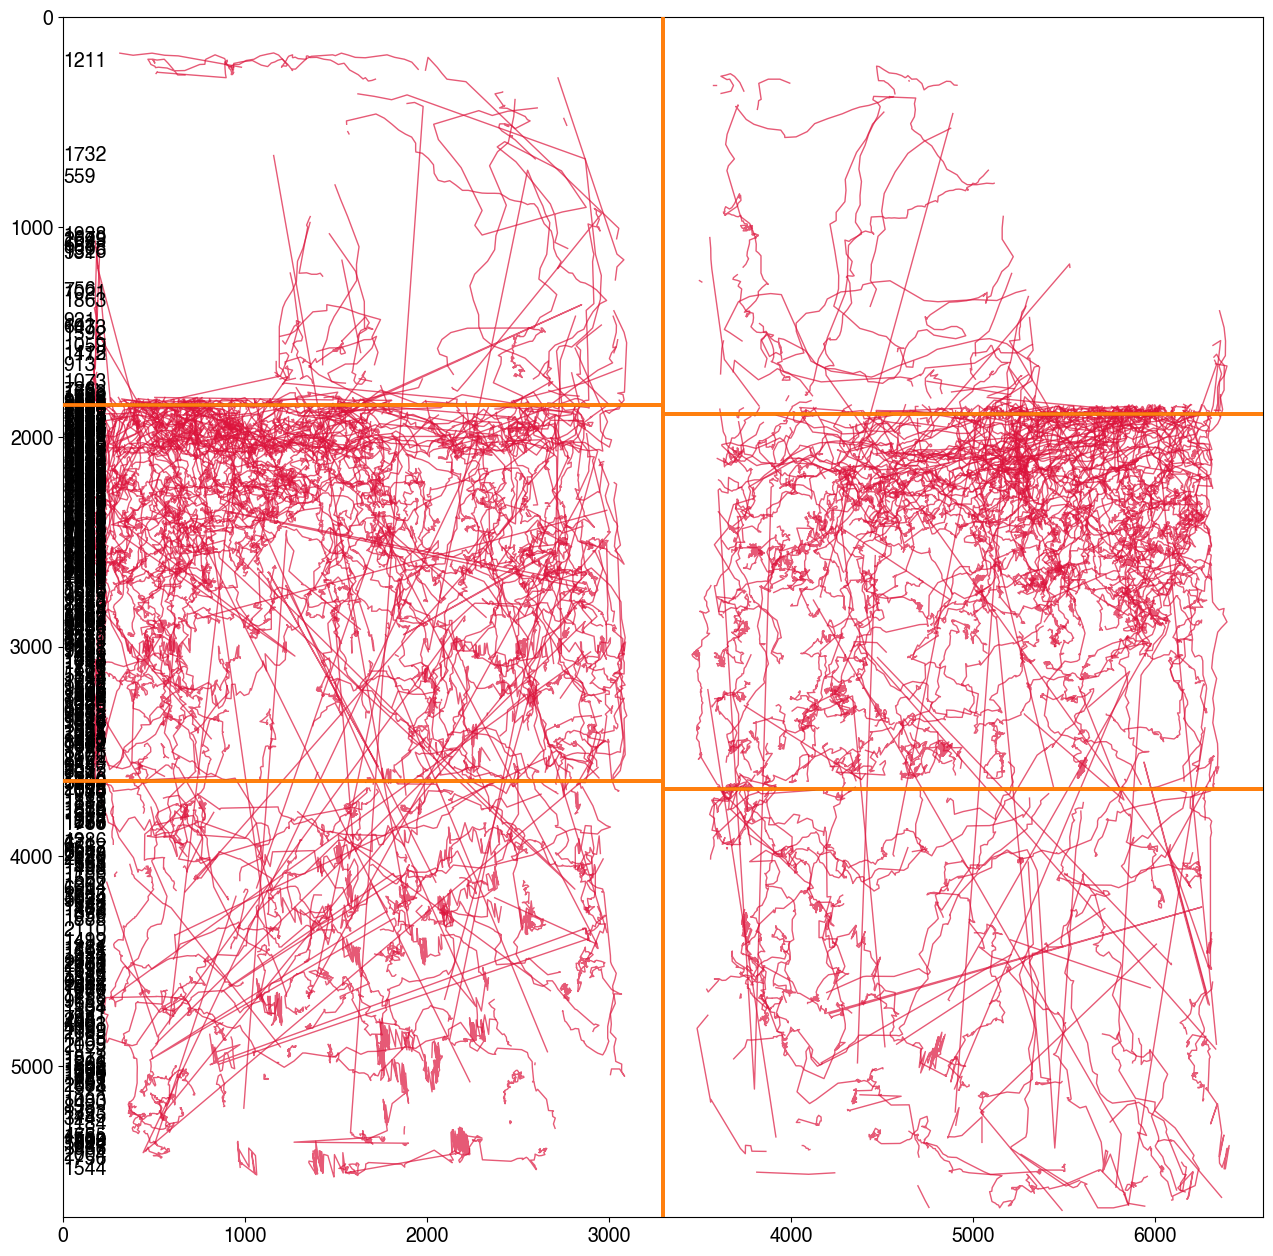

In [358]:
# plot all first-festoon histories on same plot
ax = []
for beeID in beeIDs:
    #print(beeID)
    ax = plot_func(beeID,ax=ax)

# 2024/5/10 can we see any sudden bursts of speed?

As computed in the section `Data processing to calculate metrics` in `Data processing - 1 - metrics and dataframes.ipynb`, speeds in `dfFiveMinutes` are in units of pixels per second.  Observations separated by >1 second are filtered out.

Text(0.5, 0, 'Speed, 90th percentile (cm/s)')

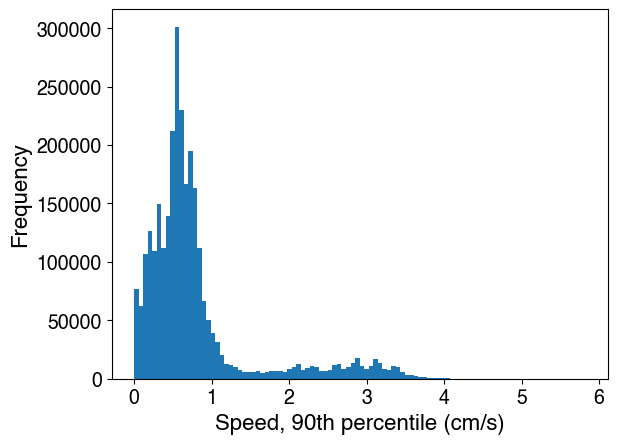

In [485]:
pixels_per_cm = 80
(dfFiveMinute['Speed 90th quantile']/pixels_per_cm).plot.hist(bins=100)
plt.xlabel('Speed, 90th percentile (cm/s)')

In [553]:
# add cohort names to the dataframe
dfFiveMinute['Cohort name'] = [ bd.cohort_names[int(cid)] for cid in dfFiveMinute['Cohort ID'] ]

In [586]:
# restrict to bees that at some point join the festoon
festoon_sum = dfFiveMinute.groupby('Bee unique ID').sum()['Festoon']
festooner_bees = [ int(uid) for uid in festoon_sum[festoon_sum > 0].index ]
dfFiveMinute_festooners = dfFiveMinute[dfFiveMinute['Bee unique ID'].isin(festooner_bees)]
print("There are {} bees that festoon at some point, out of a total {} bees.".format(len(festooner_bees),
                                                                                     len(dfFiveMinute['Bee unique ID'].unique())))

There are 1595 bees that festoon at some point, out of a total 2056 bees.


In [599]:
non_drone_cohorts = [ name for name in bd.cohort_names if not name.endswith('_drones') ]

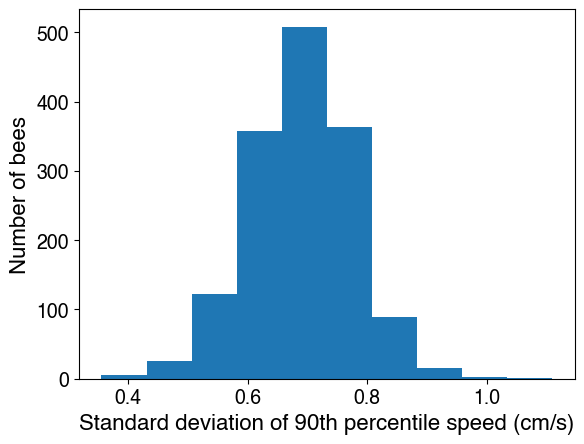

In [601]:
# let's look for bees with largest standard deviation of speed across the day.  
# we will only look at those bees that do at some point join the festoon.
# we will also filter out the drones for now
dfFiveMinute_festooner_non_drones = dfFiveMinute_festooners[dfFiveMinute_festooners['Cohort name'].isin(non_drone_cohorts)]
std_fast_speeds = dfFiveMinute_festooner_non_drones.groupby('Bee unique ID')['Speed 90th quantile'].std()/pixels_per_cm
std_fast_speeds.plot.hist()
plt.xlabel('Standard deviation of 90th percentile speed (cm/s)')
plt.ylabel('Number of bees');

In [616]:
large_std_fast_speeds = std_fast_speeds.dropna().sort_values(ascending=False).iloc[:500]
large_std_bees = [ int(uid) for uid in large_std_fast_speeds.index ]

In [613]:
large_std_bees[:10]

[2556, 1795, 2420, 2400, 1009, 2352, 1221, 865, 2528, 2249]

In [604]:
std_fast_speeds.loc[1795]

0.9915073929086431

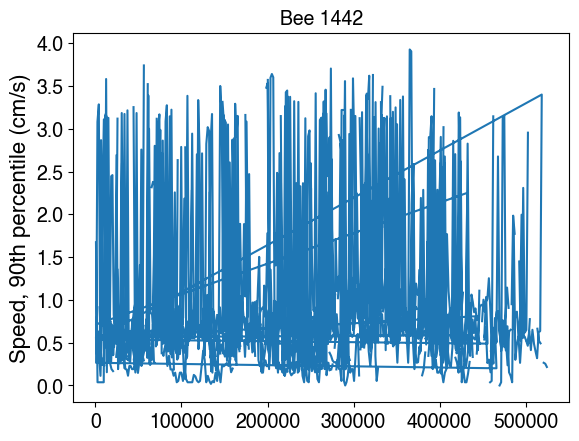

In [619]:
for uid in large_std_bees[100:101]:
    (dfFiveMinute[dfFiveMinute['Bee unique ID']==uid]['Speed 90th quantile']/pixels_per_cm).plot()
    plt.title("Bee {}".format(uid))
    plt.ylabel('Speed, 90th percentile (cm/s)')

Text(0.5, 0, 'Speed, 90th percentile (cm/s)')

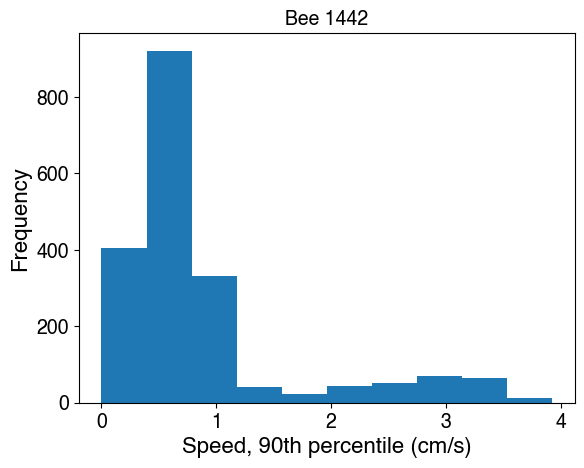

In [620]:
(dfFiveMinute[dfFiveMinute['Bee unique ID']==uid]['Speed 90th quantile']/pixels_per_cm).plot.hist()
plt.title("Bee {}".format(uid))
plt.xlabel('Speed, 90th percentile (cm/s)')

In [610]:
# Definitely see two behavioral states here.  Are these the "drone" bees? (I now filter out drone bees)
for uid in large_std_bees:
    names = dfFiveMinute[dfFiveMinute['Bee unique ID']==uid]['Cohort name'].unique()
    assert(len(names)==1)
    print("Bee {} is in cohort {}.".format(uid,names[0]))

Bee 2556 is in cohort delta.
Bee 1795 is in cohort charlie.
Bee 2420 is in cohort delta.
Bee 2400 is in cohort delta.
Bee 1009 is in cohort 4_workers.
Bee 2352 is in cohort delta.
Bee 1221 is in cohort alpha.
Bee 865 is in cohort 4_workers.
Bee 2528 is in cohort delta.
Bee 2249 is in cohort delta.


In [598]:
# note that drone bees festoon somewhat less, but not never
dfFiveMinute.groupby('Cohort name')['Festoon'].mean()

Cohort name
1_workers          3.406397
2_workers          2.656339
3_workers         10.581241
4_workers          2.804388
alpha              2.415362
bravo              3.196108
charlie            2.156714
charlie_drones     0.112258
delta              0.505759
delta_drones       0.877235
Name: Festoon, dtype: float64